# McCaul-Weisman Analytic Sounding With Sounding Parameters
  
Tasks:
- Generate a sounding using the approach of McCaul and Weisman (2001, *MWR*)
- Compute various thermodynamic parameters
- Plot a skew-$T$, log$p$ diagram using MetPy
- Plot vertical profiles of pseudoadiabatic and reversible thermodynamic parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
import MetAnalysis.src.idealized_sounding_fcts as isf

In [2]:
# Create a McCaul-Weisman analytic sounding with LCL = 1000 m and mixed-layer depth = 2000 m

z = np.arange(0, 20001, 50)    # vertical levels (m)
cape = 2000.                   # sounding CAPE (J / kg)
T_sfc = 298.3                  # surface temperature (K)
pbl_lapse = 0.009              # lapse rate beneath the LCL (K / m). Controls the CIN
ml_depth = 2000.               # mixed-layer depth (m)
thetae = 335.                  # mixed-layer thetae value (K). thetae and T_sfc control the LCL

MW_sounding = isf.mccaul_weisman(z, E=cape, T_sfc=T_sfc, pbl_lapse=pbl_lapse,
                                 pbl_depth=ml_depth, thetae_pbl=thetae)

# Analytic sounding is saved as a pandas DataFrame
MW_sounding.head()

C:\Users\smurd\Documents\python_scripts\MetAnalysis\src\idealized_sounding_fcts.py:467: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return qv0 - get_qvs(DALR(T, np.array([p0, p]))[-1], p)
C:\Users\smurd\Documents\python_scripts\MetAnalysis\src\idealized_sounding_fcts.py:467: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return qv0 - get_qvs(DALR(T, np.array([p0, p]))[-1], p)


,z,prs,T,qv,Td
0,0,100000.000000,298.30,0.012543,290.430616
1,50,99431.427666,297.85,0.012530,290.323854
2,100,98865.229444,297.40,0.012516,290.217023
3,150,98301.399029,296.95,0.012503,290.110074
4,200,97739.930111,296.50,0.012489,290.003030


In [3]:
# Compute surface-based pseudoadiabatic parameters

# Extract sounding profiles b/c isf.getcape can only accept floats or arrays, not pd.Series
p = MW_sounding['prs'].values
T = MW_sounding['T'].values
qv = MW_sounding['qv'].values

gc_out = isf.getcape(p, T, qv)

names = ['SBCAPE', 'SBCIN', 'SBLCL', 'SBLFC', 'SBEL']
units = ['J / kg', 'J / kg', 'm', 'm', 'm']

print('Pseudoadibatic Parameters')
print('-------------------------')
for val, n, u in zip(gc_out, names, units):
    print('%s = %.2f %s' % (n, val, u))

Pseudoadibatic Parameters
-------------------------
SBCAPE = 1999.93 J / kg
SBCIN = 36.98 J / kg
SBLCL = 999.29 m
SBLFC = 2187.44 m
SBEL = 12459.42 m


In [4]:
# Compute surface-based reversible parameters

gc_out = isf.getcape(p, T, qv, adiabat=2)

names = ['SBCAPE', 'SBCIN', 'SBLCL', 'SBLFC', 'SBEL']
units = ['J / kg', 'J / kg', 'm', 'm', 'm']

print('Reversible Parameters')
print('---------------------')
for val, n, u in zip(gc_out, names, units):
    print('%s = %.2f %s' % (n, val, u))

Reversible Parameters
---------------------
SBCAPE = 1452.65 J / kg
SBCIN = 53.35 J / kg
SBLCL = 999.29 m
SBLFC = 2366.27 m
SBEL = 12472.98 m


Text(0.5, 1.0, 'McCaul-Weisman Sounding with LCL = 999.3 m')

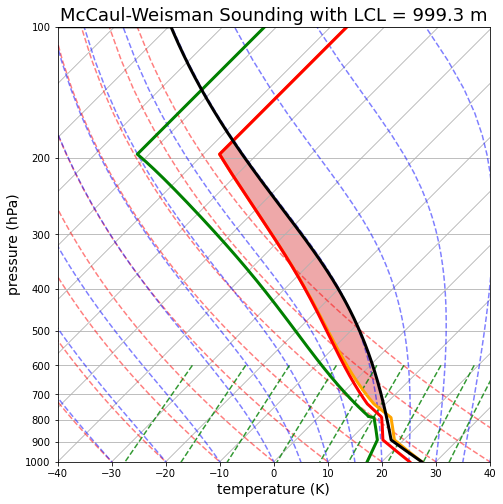

In [5]:
# Use MetPy to plot a skew-T, log p diagram

fig = plt.figure(figsize=(8, 8))
skew = SkewT(fig=fig, rotation=45)

# Plot environmental profile with virtual temperature correction
Tv = isf.getTv(T, qv)
skew.plot(p * 0.01, Tv - 273.15, 'orange', linewidth=3.0)

skew.plot(p * 0.01, T - 273.15, 'r', linewidth=3.0)
skew.plot(p * 0.01, MW_sounding['Td'] - 273.15, 'g', linewidth=3.0)

# Plot surface-based pseudoadiabatic parcel path (with Tv correction)
gc_out = isf.getcape(p, T, qv, returnTHV=True)
parcel_sb_Tv = isf.getTfromTheta(gc_out[-1], p)
skew.plot(p * 0.01, parcel_sb_Tv - 273.15, 'k', linewidth=3.0)

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.shade_cape(p * 0.01, Tv - 273.15, parcel_sb_Tv - 273.15)

skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1000.0, 100.0)

plt.ylabel('pressure (hPa)', size=14)
plt.xlabel('temperature (K)', size=14)
plt.title('McCaul-Weisman Sounding with LCL = %.1f m' % gc_out[2], size=18)

Text(0.5, 0.98, 'Vertical Profiles of Sounding Parameters')

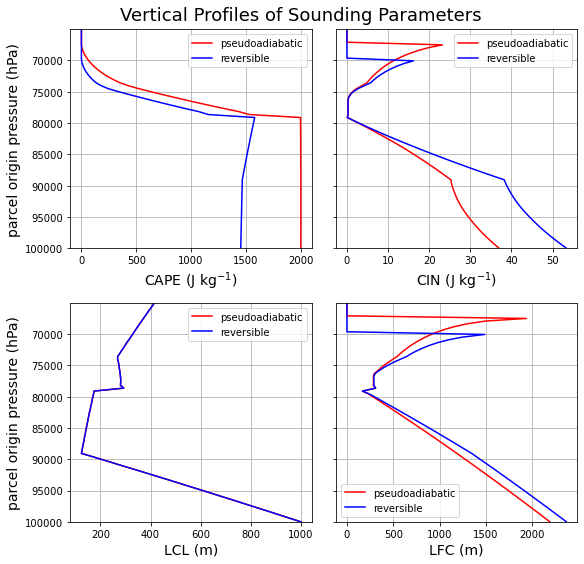

In [6]:
# Plot vertical profiles of pseudoadiabatic and reversible sounding parameters

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
plt.subplots_adjust(left=0.1, bottom=0.085, right=0.98, top=0.94, hspace=0.25, wspace=0.1)

# Compute vertical profiles of sounding parameters
for i, (adbt, c) in enumerate(zip(['pseudoadiabatic', 'reversible'], ['r', 'b'])):
    snd_prof, _ = isf.param_vprof(p, T, qv, 100000., 65000., adiabat=(i+1))
    for j, param in enumerate(['CAPE', 'CIN', 'zlcl', 'zlfc']):
        axes[int(j/2), j%2].plot(snd_prof[param], snd_prof['p'], c=c, label=adbt)

for i, xlabel in enumerate(['CAPE (J kg$^{-1}$)', 'CIN (J kg$^{-1}$)', 'LCL (m)', 'LFC (m)']):
    ax = axes[int(i/2), i%2]
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylim(snd_prof['p'].max(), snd_prof['p'].min())
    ax.grid()
    ax.legend()
    
for i in range(2):
    axes[i, 0].set_ylabel('parcel origin pressure (hPa)', size=14)
    
plt.suptitle('Vertical Profiles of Sounding Parameters', size=18)